# Coding Drill 01

## 1. Target

- Get the set-up right
- Set Transforms
- Set Data Loader
- Set Basic Working Code
- Set Basic Training  & Test Loop

## Key Updates

- Data
  - Enabled data-trasnforms for training (normalized them) 

- Model: This will be the baseline model to tune further
  - Utilized Batch Normalization, Dropouts

- Training
 - Lets start with 20 EPOCHs

## 2. Result

- Params: `13,808`
- Train Accuracy: `99.36%`
- Test Accuracy : `99.50%`

## 3. Analysis

This is the initial model 
- The training and test accuracies are shifting up and down
- The test to train accuracy gap is consistent towards the end
- The model is not overfitting
- Now the next target is to reduce the number of params (<10K, still maintaining the accuracy)


# Import Libraries

In [ ]:
# import all the required torch functions
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


# Include Data Transformations

- We first start with defining our data transformations.
- We need to think what our data is and how can we augment it to represent  represent correctly which it might not see otherwise. 

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                            # Note the difference between (0.1307) and (0.1307,)
                        ])

# Test Phase transformations
test_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])

# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Check for GPU availability

In [ ]:
SEED = 1

# CUDA? Check for GPU availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Setup Seed, for reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The Model

- Let's start with model from where we achieved < 20K params (Earlier assignment S3) 

In [ ]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary

# Once we have GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).
# test if PyTorch has access to a GPU
use_cuda = torch.cuda.is_available()

# if GPU is availble use it, if not use CPU. allocate device and assign n/w to it
device = torch.device("cuda" if use_cuda else "cpu")

# configure the model to be loaded on the device decided above.
model = Net().to(device)

# input image size: 28x28, Input_channels: 1
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
    

# Training and Testing

- Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 
- Let's write train and test functions

In [ ]:
# Tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  
  model.train() # set the model with training mode (this is the default mode)

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init. 
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict. 
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return 100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return 100. * correct / len(test_loader.dataset)


In [ ]:
from torch.optim.lr_scheduler import StepLR

# move the model to the required device, GPU if available, if not on CPU.
model = Net().to(device)

# create an optimizer (SGD) with required parameters, 
# model.parameters() - these are the model parameters to optimize, 
# learning-rate lr=0.01 and momentum-0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Configure epochs to train for
EPOCHS = 20

prev_train_acc = -1
prev_test_acc = -1
train_accuracy = 0
test_accuracy = 0

# run single epoch as of now.
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}')

    # train the model loaded on the device with the required optimizer
    train_accuracy = train(model, device, train_loader, optimizer, epoch)

    # set to the next lr params
    #scheduler.step()

    # we need to evaluate on test data
    test_accuracy = test(model, device, test_loader)


    # check difference from previous accuracies for better understanding
    if -1 == prev_train_acc:
      prev_train_acc = train_accuracy
    if -1 == prev_test_acc:
      prev_test_acc = test_accuracy

    print(f'train_acc_diff: {train_accuracy - prev_train_acc:.3f} test_acc_diff: {test_accuracy - prev_test_acc:.3f} test_train_diff: {test_accuracy - train_accuracy:.3f}\n')
    prev_train_acc = train_accuracy
    prev_test_acc = test_accuracy


Epoch: 1


Loss=0.13806068897247314 Batch_id=468 Accuracy=86.97: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]



Test set: Average loss: 0.0600, Accuracy: 9826/10000 (98.26%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 11.292

Epoch: 2


Loss=0.05502896010875702 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]



Test set: Average loss: 0.0425, Accuracy: 9880/10000 (98.80%)

train_acc_diff: 10.910 test_acc_diff: 0.540 test_train_diff: 0.922

Epoch: 3


Loss=0.02913057990372181 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]



Test set: Average loss: 0.0310, Accuracy: 9910/10000 (99.10%)

train_acc_diff: 0.425 test_acc_diff: 0.300 test_train_diff: 0.797

Epoch: 4


Loss=0.07704124599695206 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]



Test set: Average loss: 0.0316, Accuracy: 9903/10000 (99.03%)

train_acc_diff: 0.315 test_acc_diff: -0.070 test_train_diff: 0.412

Epoch: 5


Loss=0.02594105340540409 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]



Test set: Average loss: 0.0342, Accuracy: 9902/10000 (99.02%)

train_acc_diff: 0.143 test_acc_diff: -0.010 test_train_diff: 0.258

Epoch: 6


Loss=0.0938568115234375 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]



Test set: Average loss: 0.0261, Accuracy: 9915/10000 (99.15%)

train_acc_diff: 0.030 test_acc_diff: 0.130 test_train_diff: 0.358

Epoch: 7


Loss=0.03207976743578911 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]



Test set: Average loss: 0.0248, Accuracy: 9929/10000 (99.29%)

train_acc_diff: 0.098 test_acc_diff: 0.140 test_train_diff: 0.400

Epoch: 8


Loss=0.017725275829434395 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]



Test set: Average loss: 0.0229, Accuracy: 9936/10000 (99.36%)

train_acc_diff: 0.045 test_acc_diff: 0.070 test_train_diff: 0.425

Epoch: 9


Loss=0.008379105478525162 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]



Test set: Average loss: 0.0225, Accuracy: 9935/10000 (99.35%)

train_acc_diff: 0.100 test_acc_diff: -0.010 test_train_diff: 0.315

Epoch: 10


Loss=0.031015729531645775 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]



Test set: Average loss: 0.0249, Accuracy: 9921/10000 (99.21%)

train_acc_diff: 0.035 test_acc_diff: -0.140 test_train_diff: 0.140

Epoch: 11


Loss=0.043649788945913315 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.39it/s]



Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

train_acc_diff: 0.098 test_acc_diff: 0.040 test_train_diff: 0.082

Epoch: 12


Loss=0.014292363077402115 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]



Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

train_acc_diff: -0.035 test_acc_diff: 0.060 test_train_diff: 0.177

Epoch: 13


Loss=0.007125433534383774 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]



Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

train_acc_diff: 0.013 test_acc_diff: 0.010 test_train_diff: 0.173

Epoch: 14


Loss=0.035428665578365326 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]



Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

train_acc_diff: 0.005 test_acc_diff: 0.030 test_train_diff: 0.198

Epoch: 15


Loss=0.010968786664307117 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]



Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

train_acc_diff: 0.065 test_acc_diff: -0.140 test_train_diff: -0.007

Epoch: 16


Loss=0.0317789688706398 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]



Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

train_acc_diff: -0.015 test_acc_diff: 0.170 test_train_diff: 0.178

Epoch: 17


Loss=0.014431237243115902 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]



Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

train_acc_diff: 0.040 test_acc_diff: -0.020 test_train_diff: 0.118

Epoch: 18


Loss=0.02819780260324478 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]



Test set: Average loss: 0.0187, Accuracy: 9948/10000 (99.48%)

train_acc_diff: 0.043 test_acc_diff: 0.120 test_train_diff: 0.195

Epoch: 19


Loss=0.0029878888744860888 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]



Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

train_acc_diff: 0.005 test_acc_diff: -0.040 test_train_diff: 0.150

Epoch: 20


Loss=0.0053240470588207245 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]



Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

train_acc_diff: 0.065 test_acc_diff: 0.060 test_train_diff: 0.145



# Move tesnors to numpy as required

- train_losses is a list, but train_losses[i] is a tensor
- all others are numpy

## APIs to use

- To go from np.array to cpu Tensor    => torch.from_numpy().
- To go from cpu Tensor to gpu Tensor  => .cuda()
- To go from a Tensor that requires_grad to one that does not => .detach() 
- To go from a gpu Tensor to cpu Tensor => .cpu()
- To gp from a cpu Tensor to np.array   => .numpy()

In [ ]:
# type(train_losses), type(train_losses[0])

for i, loss in enumerate(train_losses):
  train_losses[i] = loss.detach().cpu().numpy()

# Plot the model's learning progress

- Plot training and test accuracies

Text(0.5, 1.0, 'Test Accuracy')

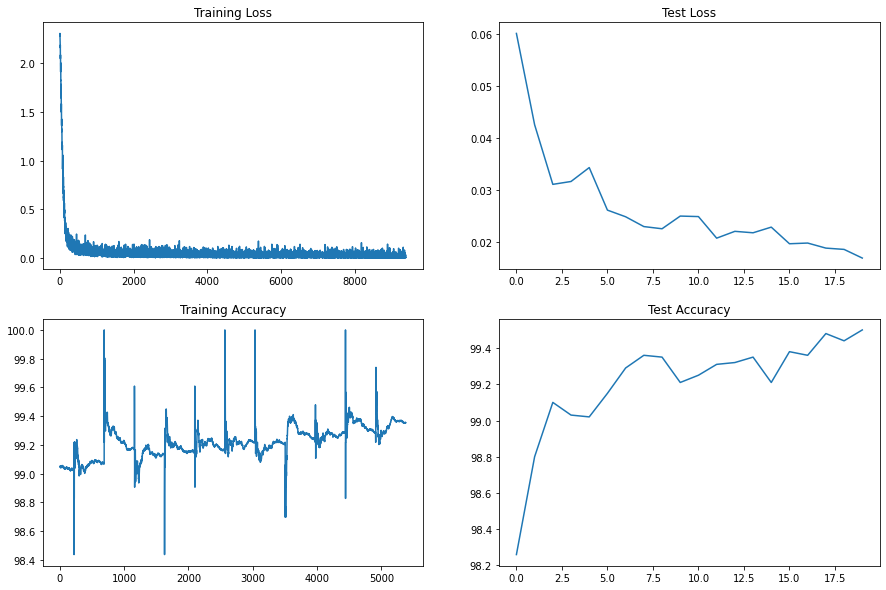

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")